# Pitstop Arabia
Pitstop arabia is an online tyre ordering service. You order the tyre online, they purchase it and direct you to one of their locations for it to be installed. I have aquiered data pertaining to the sales of the tyres themselves and the installer locations.

The goal of this project is to predict how many tyres a location may need, as well as what brand or type of tyre.

Let's start by importing our standard libraries: 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

And read in the data: 

In [3]:
tyres = pd.read_csv("tire_data/tyre_data_analysis.csv")

print("Size of the data set: ", tyres.shape)
print("What information we have on 1 purchase: \n", tyres.columns)

Size of the data set:  (2574, 24)
What information we have on 1 purchase: 
 Index(['Order Date', 'Order #', 'Order Status', 'Service Date',
       'Installer Name', 'Installer Address', 'Installer City', 'Vehicle Reg',
       'Vehicle Make', 'Vehicle Model', 'Vehicle Year ', 'SKU', 'Brand',
       'Name', 'QTY Ordered', 'width', 'height', 'rim size', 'year',
       'Subtotal ', 'Shipping & Handling ', 'Discount', 'Tax Amount',
       'Grand Total'],
      dtype='object')


In [4]:
tyres.head(6)

,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,QTY Ordered,width,height,rim size,year,Subtotal,Shipping & Handling,Discount,Tax Amount,Grand Total
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,R19508,bmw,3-series,...,4,225,45,18,2020.0,3588.0,0.0,0.0,0.0,3588.0
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,D34841,toyota,fj-cruiser,...,4,275,70,16,2019.0,2396.0,0.0,0.0,0.0,2396.0
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,67790,mercedes,c-class-amg,...,2,NaN,NaN,NaN,NaN,998.0,0.0,0.0,0.0,998.0
3,5/1/2016 10:21,100000233.0,complete,8/1/2016,ZDegree,"Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel S...",Dubai,82794,Honda,MRV,...,2,NaN,NaN,NaN,NaN,870.0,0.0,0.0,0.0,870.0
4,7/1/2016 17:22,100000235.0,complete,16-01-16,TyrePlus,"behind Honda Showroom / Oasis Centre , Opposit...",Dubai,44557k,mercedes,e-class,...,2,255,35,18,2020.0,3752.0,0.0,0.0,0.0,3752.0
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,235,40,18,2019.0,NaN,NaN,NaN,NaN,NaN


# Fixing 2nd tyre order issue

Sometimes, a customer has differnet tyres in the back and front, and when that happens a new row is added and the information about the second tire is added to the next row. I would hate to throw this data away, so I will try and make some new features to accomadate these anomolies. Let's take a look at an example, say row 5: 

In [5]:
tyres.iloc[5,:]

Order Date                        NaN
Order #                           NaN
Order Status                      NaN
Service Date                      NaN
Installer Name                    NaN
Installer Address                 NaN
Installer City                    NaN
Vehicle Reg                       NaN
Vehicle Make                      NaN
Vehicle Model                     NaN
Vehicle Year                      NaN
SKU                     PIR1200007350
Brand                         Pirelli
Name                        P Zero MO
QTY Ordered                         2
width                             235
height                             40
rim size                           18
year                             2019
Subtotal                          NaN
Shipping & Handling               NaN
Discount                          NaN
Tax Amount                        NaN
Grand Total                       NaN
Name: 5, dtype: object

It would be a shame to simply throw this data away. Lets add 7 new features to accomodate the 2nd set of tyres, and add the QTY (Quantity) to the existing one. 

In [6]:
tyres['SKU Tyres 2'] = np.NaN
tyres['2nd Brand'] = np.NaN
tyres['Name 2nd Tyre(s)'] = np.NaN
tyres['QTY 2nd Order'] = np.NaN
tyres['width 2'] = np.NaN
tyres['height 2'] = np.NaN 
tyres['rim size 2'] = np.NaN
tyres['year 2'] = np.NaN

In [7]:
tyres.head(3)

,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,Tax Amount,Grand Total,SKU Tyres 2,2nd Brand,Name 2nd Tyre(s),QTY 2nd Order,width 2,height 2,rim size 2,year 2
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,R19508,bmw,3-series,...,0.0,3588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,D34841,toyota,fj-cruiser,...,0.0,2396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,67790,mercedes,c-class-amg,...,0.0,998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We have added the features, let's grab every 2nd tyre row. We can identify them by the dfact that they have no order number: 

In [8]:
nan_rows = tyres[tyres["Order #"].isna() == True]
print(nan_rows.shape)
nan_rows.head(3)

(212, 32)


,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,Tax Amount,Grand Total,SKU Tyres 2,2nd Brand,Name 2nd Tyre(s),QTY 2nd Order,width 2,height 2,rim size 2,year 2
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
old_columns = ["SKU", "Brand", "Name", "QTY Ordered", "width", "height", "rim size", "year"]
new_columns = ['SKU Tyres 2','2nd Brand','Name 2nd Tyre(s)','QTY 2nd Order','width 2','height 2','rim size 2','year 2']

#Transfering data from the extra column into my new variables
for i in range(len(old_columns)):
    for row in nan_rows.index:
        tyres.loc[row-1,new_columns[i]] = nan_rows.loc[row, old_columns[i]]

And now that we have saved the info, we can drop the rows that have no order number:

In [10]:
full_tyres = tyres[tyres["Order #"].isna() == False]
full_tyres.reset_index(inplace = True)
full_tyres.drop(["index"], axis = 1, inplace = True)
full_tyres.head(3)

C:\Users\MusaR\Anaconda3\envs\pitstop\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Order Date,Order #,Order Status,Service Date,Installer Name,Installer Address,Installer City,Vehicle Reg,Vehicle Make,Vehicle Model,...,Tax Amount,Grand Total,SKU Tyres 2,2nd Brand,Name 2nd Tyre(s),QTY 2nd Order,width 2,height 2,rim size 2,year 2
0,2/1/2016 13:01,100000225.0,complete,4/1/2016,ZDegree,"Hessa - ENOC Petrol Station, Al Khail Rd, \r\n...",Dubai,R19508,bmw,3-series,...,0.0,3588.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4/1/2016 16:15,100000230.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,D34841,toyota,fj-cruiser,...,0.0,2396.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4/1/2016 18:17,100000231.0,complete,6/1/2016,TyrePlus,"Al Barsha Mall, Basement 2 ,23rd St. Al Barsha 2",Dubai,67790,mercedes,c-class-amg,...,0.0,998.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
full_tyres.shape

(2362, 32)

## Converting to correct data types
Some columns don't have the correct type, which is a problem for our modeling. I also want to make sure that most (if not all) rows are binary, which further helps with modeling. Let's see what they are currently: 

In [12]:
full_tyres.dtypes

Order Date               object
Order #                 float64
Order Status             object
Service Date             object
Installer Name           object
Installer Address        object
Installer City           object
Vehicle Reg              object
Vehicle Make             object
Vehicle Model            object
Vehicle Year             object
SKU                      object
Brand                    object
Name                     object
QTY Ordered               int64
width                    object
height                   object
rim size                 object
year                    float64
Subtotal                float64
Shipping & Handling     float64
Discount                float64
Tax Amount              float64
Grand Total             float64
SKU Tyres 2              object
2nd Brand                object
Name 2nd Tyre(s)         object
QTY 2nd Order           float64
width 2                  object
height 2                 object
rim size 2               object
year 2  

Let's solve this problem row by row, we'll begin with the order date: 

In [13]:
full_tyres.loc[:,"Order Date"] = pd.to_datetime(full_tyres.loc[:,"Order Date"]) #Order Date (date time)

full_tyres.loc[:,"Service Date"] = pd.to_datetime(full_tyres.loc[:,"Service Date"]) #Service Date (date time)

#They were also out of order, so I sort them here: 
full_tyres.sort_values(by = ['Order Date']);

C:\Users\MusaR\Anaconda3\envs\pitstop\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Now for the order status. 

A quick peruse reveals that processing, psa_review and canceled_payfortcw can be dropped

In [14]:
full_tyres['Order Status'].unique()

array(['complete', 'closed', 'canceled_payfortcw', 'psa_review',
       'processing'], dtype=object)

In [15]:
status_to_drop = ['canceled_payfortcw','psa_review','processing']

for status in status_to_drop:
    full_tyres = full_tyres[full_tyres['Order Status'] != status]

full_tyres.reset_index(inplace = True)
full_tyres.drop(["index"], axis = 1, inplace = True)

Great! Now to deal with the Vehicle Year. There seem to be people who enter N/A differently, so let's adjust that: 

In [16]:
not_a_year = ['u', 'na','ddfd']

for i in range(len(full_tyres['Vehicle Year '])):
    if full_tyres.loc[i,'Vehicle Year '] in not_a_year:
        full_tyres.loc[i,'Vehicle Year '] = np.NaN

#Now to fill those nan values:
full_tyres['Vehicle Year '].fillna(method = 'ffill', inplace = True)

Now for the addresses, one of the most important parts. WHat I am predicting, is what amount of tires would be needed in what locations on what day. However, there is sever class imblance in terms of location usage. Below is the plotted usage of each of the locations: 

C:\Users\MusaR\Anaconda3\envs\pitstop\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\MusaR\Anaconda3\envs\pitstop\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)


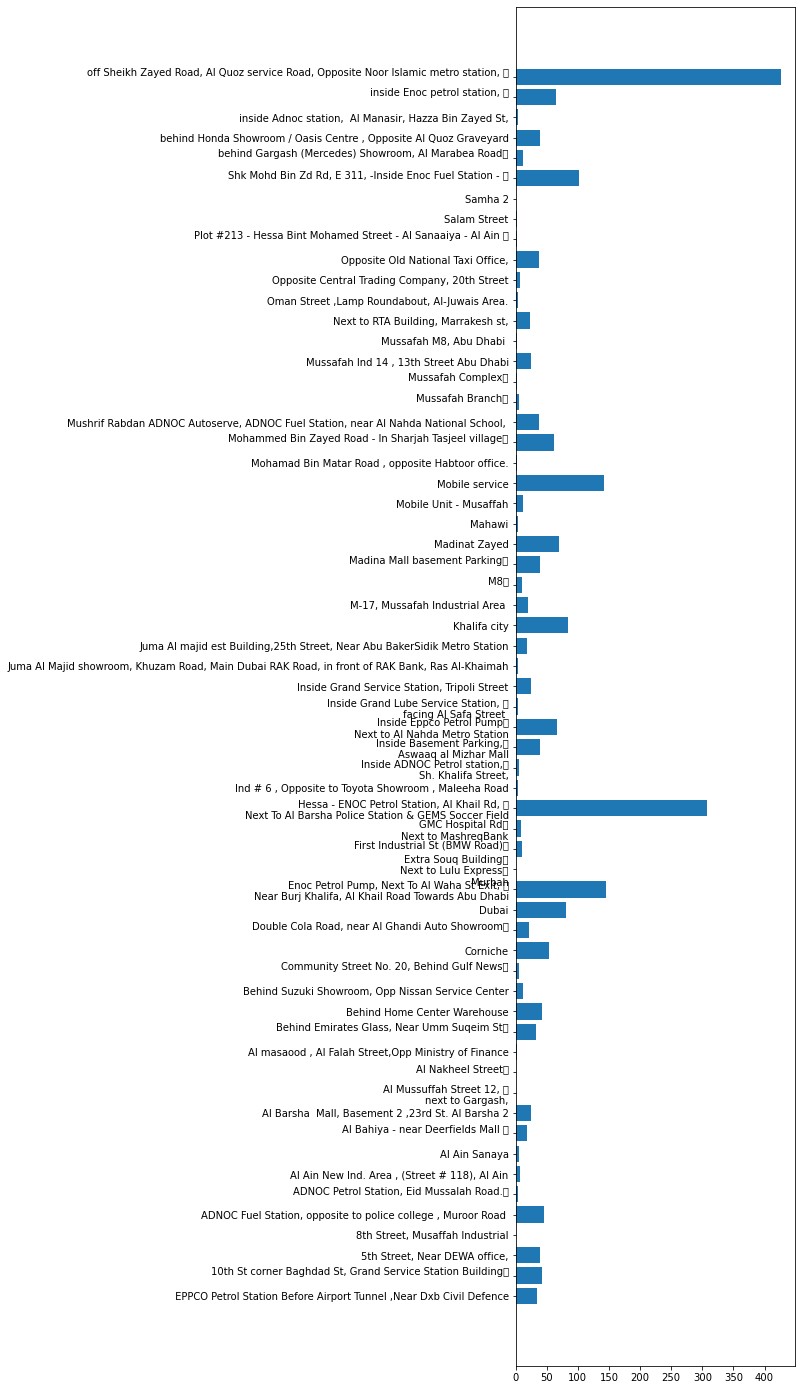

In [17]:
grouped_locations = full_tyres.groupby("Installer Address")["QTY Ordered"].count() #Group counts
grouped_locations = pd.DataFrame(grouped_locations) #Convert to DF
grouped_locations.reset_index(inplace = True) #Reset the index

#Ready for plotting!

plt.figure(figsize = (5,25))
plt.barh(grouped_locations['Installer Address'], grouped_locations['QTY Ordered'])
plt.show()

A much simpler approach would be group these locations together for plotting. We will need both the latitude and longitude of each location in order to make appropriate bounds.

Normally, I would use the google API to exchange the adress for the coordinates, however Dubai (and the middle east in general) has a problem with formal addressess, they don't really have any.

During my time in Saudi Arabia, there were addressess, but many were not formally recorded (*more of a decoration than anything else*). 
It wasn't until [2010](https://www.esri.com/news/arcnews/winter1011articles/saudi-arabia.html#:~:text=Traditionally%2C%20home%20and%20street%20addresses,directly%20from%20the%20post%20office.) in Saudi Arabia and [2015](https://www.citymetric.com/horizons/buildings-dubai-and-abu-dhabi-didnt-have-official-addresses-thats-finally-changing-838) in the United Arab Emirates that postal codes and the like started to become used more often. It still isn't the most robust system, and many rely on landmaks like "the Emirates Mall" or "the gas station next to the Burj Khalifa" for locations. 

This lead to the (painfully) manual process of going through google maps for all 61 unique locations. Please enjoy my work below: 

In [18]:
full_tyres['Installer Address'].fillna(method = 'ffill', inplace = True)
len(full_tyres['Installer Address'].unique())

61

In [19]:
add_coo = {} #Dictionary associating each location with their respective lattitude and longitude
add_coo['Hessa - ENOC Petrol Station, Al Khail Rd, \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.066277, 55.218215)
add_coo[' \r\nNext To Al Barsha Police Station & GEMS Soccer Field'] = (25.080584, 55.215431)
add_coo['Al Barsha  Mall, Basement 2 ,23rd St. Al Barsha 2'] = (25.098187, 55.203553)
add_coo['Shk Mohd Bin Zd Rd, E 311, -Inside Enoc Fuel Station - \r\n'] = (25.059133, 55.285133)
add_coo['behind Honda Showroom / Oasis Centre , Opposite Al Quoz Graveyard'] = (25.168575, 55.241198)
add_coo['Dubai'] = (25.152925, 55.262578)
add_coo['inside Enoc petrol station, \r\n'] = (25.150143, 55.244540)
add_coo['10th St corner Baghdad St, Grand Service Station Building\r\n'] = (25.199583, 55.441530)
add_coo['Behind Suzuki Showroom, Opp Nissan Service Center'] = (25.259433, 55.334238)
add_coo['Next to RTA Building, Marrakesh st,'] = (25.233531, 55.356299)
add_coo['Inside Grand Service Station, Tripoli Street'] = (25.199680, 55.441432)
add_coo['M-17, Mussafah Industrial Area '] = (24.364980, 54.491010)
add_coo['Enoc Petrol Pump, Next To Al Waha St Exit, \r\nNear Burj Khalifa, Al Khail Road Towards Abu Dhabi'] = (25.211362, 55.259310)
add_coo['Khalifa city'] = (24.405996, 54.602742)
add_coo['Corniche'] = (25.256534, 55.306121)
add_coo['Behind Emirates Glass, Near Umm Suqeim St\r\n'] = (25.114569, 55.222304)
add_coo['Al masaood , Al Falah Street,Opp Ministry of Finance'] = (24.485140, 54.378802)
add_coo['Salam Street'] = (24.413092, 54.503905)
add_coo['Opposite Central Trading Company, 20th Street'] = (25.129721, 55.245257)
add_coo['Plot #213 - Hessa Bint Mohamed Street - Al Sanaaiya - Al Ain \r\n'] = (24.213164, 55.760262)
add_coo['Inside Grand Lube Service Station, \r\nfacing Al Safa Street '] = (25.207087, 55.268465)
add_coo['behind Gargash (Mercedes) Showroom, Al Marabea Road\r\n'] = (25.130630, 55.219551)
add_coo['Mobile Unit - Musaffah'] = (24.346592, 54.487272)
add_coo['Juma Al majid est Building,25th Street, Near Abu BakerSidik Metro Station'] = (25.270249, 55.326704)
add_coo[' EPPCO Petrol Station Before Airport Tunnel ,Near Dxb Civil Defence'] = (25.267141, 55.355484)
add_coo['Inside ADNOC Petrol station,\r\nSh. Khalifa Street,'] = (24.499881, 54.368962)
add_coo['First Industrial St (BMW Road)\r\n'] = (25.320569, 55.401860)
add_coo['Madinat Zayed'] = (23.666361, 53.695055)
add_coo['ADNOC Fuel Station, opposite to police college , Muroor Road '] = (24.436862, 54.422066)
add_coo['Opposite Old National Taxi Office,'] = (25.115186, 55.220820)
add_coo['Samha 2'] = (24.671022, 54.759717)
add_coo['M8\r\n'] = (25.286304, 55.478272)
add_coo['Mohamad Bin Matar Road , opposite Habtoor office.'] = (25.166264, 55.225182)
add_coo['Mahawi'] = (24.349637, 54.584522)
add_coo['Mussafah Branch\r\n'] = (24.377345, 54.497503)
add_coo['Double Cola Road, near Al Ghandi Auto Showroom\r\n'] = (25.332196, 55.470854)
add_coo['Inside Eppco Petrol Pump\r\nNext to Al Nahda Metro Station'] = (25.274270, 55.368493)
add_coo['off Sheikh Zayed Road, Al Quoz service Road, Opposite Noor Islamic metro station, \r\n'] = (25.154543, 55.228176)
add_coo['Mobile service'] = (24.5, 54.3) #####981234798012374089271940892314
add_coo['Juma Al Majid showroom, Khuzam Road, Main Dubai RAK Road, in front of RAK Bank, Ras Al-Khaimah'] = (25.707212, 55.970226)
add_coo['Mohammed Bin Zayed Road - In Sharjah Tasjeel village\r\n'] = (25.343653, 55.473574)
add_coo['Madina Mall basement Parking\r\n'] = (25.281752, 55.398280)
add_coo['Inside Basement Parking,\r\nAswaaq al Mizhar Mall'] = (25.246192, 55.452685)
add_coo['Al Mussuffah Street 12, \r\nnext to Gargash,'] = (24.360125, 54.504070)
add_coo['Mussafah Ind 14 , 13th Street Abu Dhabi'] = (24.330692, 54.533828)
add_coo['Al Ain Sanaya'] = (24.179849, 55.762638)
add_coo['Oman Street ,Lamp Roundabout, Al-Juwais Area.'] = (25.769444, 55.974937)
add_coo['Al Ain New Ind. Area , (Street # 118), Al Ain'] = (24.220467, 55.758508)
add_coo['ADNOC Petrol Station, Eid Mussalah Road.\r\n'] = (24.239734, 55.696923)
add_coo['Behind Home Center Warehouse'] = (25.144578, 55.230620)
add_coo['GMC Hospital Rd\r\nNext to MashreqBank'] = (25.382247, 55.462849)
add_coo['Community Street No. 20, Behind Gulf News\r\n'] = (25.258551, 55.321747)
add_coo['Mushrif Rabdan ADNOC Autoserve, ADNOC Fuel Station, near Al Nahda National School, '] = (24.436508, 54.402399)
add_coo['Ind # 6 , Opposite to Toyota Showroom , Maleeha Road'] = (25.333723, 55.399324)
add_coo['Al Bahiya - near Deerfields Mall \r\n'] = (24.521642, 54.669278)
add_coo['Mussafah Complex\r\n'] = (24.515570, 54.661096)
add_coo['Extra Souq Building\r\nNext to Lulu Express\r\nMurbah'] = (25.282827, 56.355189)
add_coo['5th Street, Near DEWA office,'] = (25.227026, 55.323806)
add_coo['inside Adnoc station,  Al Manasir, Hazza Bin Zayed St,'] = (24.456902, 54.356534)
add_coo['Mussafah M8, Abu Dhabi '] = (24.379093, 54.512613)
add_coo['8th Street, Musaffah Industrial'] = (24.373577, 54.487804)
add_coo['Al Nakheel Street\r\n'] = (24.448178, 54.398642)

Now, I'll add the lattitude and longitude values as new columns in the data frame. 

In [20]:
full_tyres['Lattitude'] = 0
full_tyres['Longitude'] = 0

for i in range(len(full_tyres['Lattitude'])):
    address = full_tyres.loc[i,'Installer Address'] #Getting the address
    full_tyres.loc[i,'Lattitude'] = add_coo[address][0] #Adding lattitude to the row
    full_tyres.loc[i,'Longitude'] = add_coo[address][1] #Adding Longitude to the row

Now I'll plot them onto the map of the UAE

In [21]:
min_lat = full_tyres['Lattitude'].min()
max_lat = full_tyres['Lattitude'].max()

min_lng = full_tyres['Longitude'].min()
max_lng = full_tyres['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))

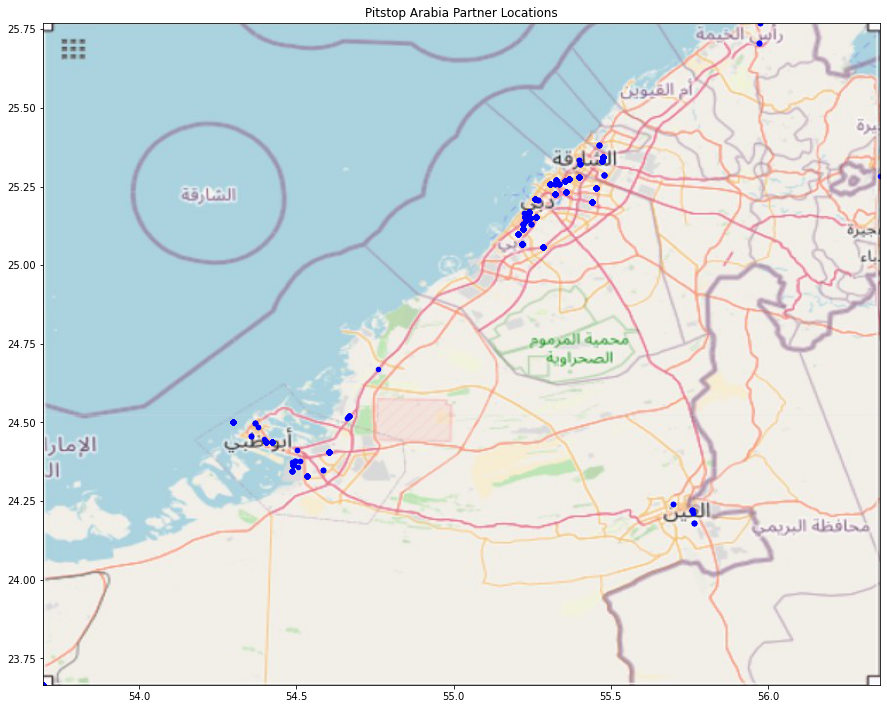

In [23]:
ruh_m = plt.imread('maps/uae_map.jpg')

fig, ax = plt.subplots(figsize = (15,15))
ax.scatter(full_tyres['Longitude'], full_tyres['Lattitude'], c='b', s=20)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

I can see from the map that the vast majority of the installations happen in both Dubai and Abu Dhabi, and the rest of the cities don't have enough influence to be considered a major part of the model.

I will split Abu Dhabi and Dubai into chunks, and make the rest of the cities there own chunk. I will then have a few groups, and I can fit a few models to predict the demand in each one. 

In [24]:
dubai = full_tyres[full_tyres['Installer City'] == 'Dubai']
abu_dhabi = full_tyres[full_tyres['Installer City'] == 'Abu Dhabi']
third_chunk = full_tyres[(full_tyres['Installer City'] != 'Abu Dhabi') & (full_tyres['Installer City'] != 'Dubai')]

dubai = dubai.reset_index().drop('index', axis = 1)
abu_dhabi = abu_dhabi.reset_index().drop('index', axis = 1)
third_chunk = third_chunk.reset_index().drop('index', axis = 1)

In [25]:
#Plotting Dubai first: 
min_lat = dubai['Lattitude'].min()
max_lat = dubai['Lattitude'].max()

min_lng = dubai['Longitude'].min()
max_lng = dubai['Longitude'].max()

BBox = ((min_lng, max_lng,      
         min_lat, max_lat))
print(min_lng, max_lng, min_lat, max_lat)

54.3 55.452685 24.346592 25.281752


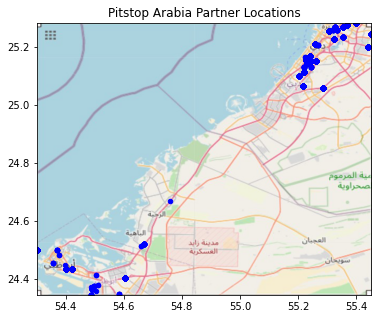

In [26]:
ruh_m = plt.imread('maps/dubai_map.jpg')

fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(full_tyres['Longitude'], full_tyres['Lattitude'], c='b', s=20)
ax.set_title('Pitstop Arabia Partner Locations')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')
plt.show()

we see 2 very distinct sections of upper dubai and lower dubai. We oculd very easily draw a line in the center (Lattititude = 24.8) and say that everyone whose `latitude > 24.8 = Upper Dubai, else Lower Dubai`

In [27]:
dubai['Section'] = 'dubai'

for i in range(len(dubai['Lattitude'])):
    if dubai.loc[i,'Lattitude'] > 24.8:
        dubai.loc[i,'Section'] = 'Upper_Dubai'
    else:
        dubai.loc[i,'Section'] = 'Lower_Dubai'

In [28]:
dubai.columns

Index(['Order Date', 'Order #', 'Order Status', 'Service Date',
       'Installer Name', 'Installer Address', 'Installer City', 'Vehicle Reg',
       'Vehicle Make', 'Vehicle Model', 'Vehicle Year ', 'SKU', 'Brand',
       'Name', 'QTY Ordered', 'width', 'height', 'rim size', 'year',
       'Subtotal ', 'Shipping & Handling ', 'Discount', 'Tax Amount',
       'Grand Total', 'SKU Tyres 2', '2nd Brand', 'Name 2nd Tyre(s)',
       'QTY 2nd Order', 'width 2', 'height 2', 'rim size 2', 'year 2',
       'Lattitude', 'Longitude', 'Section'],
      dtype='object')

We now have our first split city! Let's try and fit a model on top to get an idea as to what needs to happen with other chunks: 

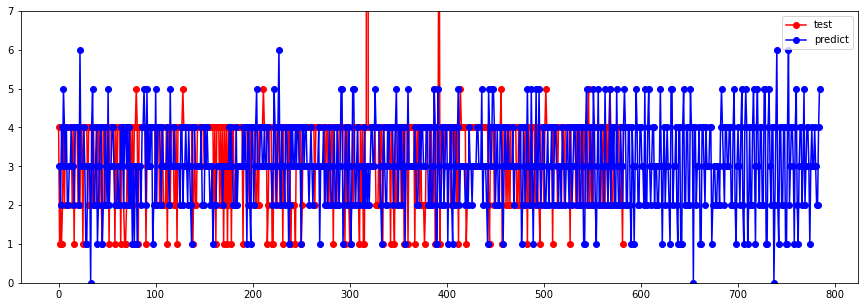

In [141]:
train = dubai['QTY Ordered'][0:1200]
test = list(dubai['QTY Ordered'][1200:-1])
from statsmodels.tsa.ar_model import AR

model = AR(train)
model_fit = model.fit(maxlag=400)


predictions = model_fit.predict(start=len(train), end=len(train)+784)

new_predictions = []
for i in predictions:
    new_predictions.append(round(i,0))

plt.figure(figsize = (15,5))
plt.plot(test, c="red", label="test", marker='o')
plt.plot(new_predictions, c="blue", label="predict", marker='o')
plt.ylim(0,7)
plt.legend()
plt.show();

In [143]:
points = 0
for i in range(len(new_predictions)):
    if train[i] == new_predictions[i] or train[i] == new_predictions[i]-1 or train[i] == new_predictions[i]+1:
        points+=1
score = points/len(predictions)
print(f"score: {round(score,3)*100}%")

score: 64.7%


In [150]:
scores = []
for i in range(10,1000,5):
    model = AR(train)
    model_fit = model.fit(maxlag=i)


    predictions = model_fit.predict(start=len(train), end=len(train)+784)

    new_predictions = []
    for j in predictions:
        new_predictions.append(round(j,0))
    
    points = 0
    for k in range(len(new_predictions)):
        if train[k] == new_predictions[k] or train[k] == new_predictions[k]-1 or train[k] == new_predictions[k]+1:
            points+=1
        print(k, end = '\r')
    score = points/len(predictions)
    scores.append(score)


In [159]:
sum(new_predictions)

2486.0

In [158]:
sum(test)

2053

In [105]:
test = dubai['QTY Ordered'][1000:-1]
test

1000    4
1001    2
1002    2
1003    4
1004    1
       ..
1780    3
1781    1
1782    4
1783    4
1784    4
Name: QTY Ordered, Length: 785, dtype: int64